<br>

<div align=center><font color=maroon size=6><b>tf.data: Build TensorFlow input pipelines</b></font></div>

<br>

<font size=4><b>References:</b></font>
1. TF2 Core: <a href="https://www.tensorflow.org/guide" style="text-decoration:none;">TensorFlow Guide</a> 
    * `TensorFlow > Learn > TensorFlow Core > `Guide > <a href="https://www.tensorflow.org/guide/data" style="text-decoration:none;">tf.data: Build TensorFlow input pipelines</a>
        * Run in <a href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/data.ipynb" style="text-decoration:none;">Google Colab</a>

<br>
<br>
<br>

The `tf.data` API enables you to build complex input pipelines from simple, reusable pieces. 

For example: 

* The pipeline for an image model might aggregate data from files in a distributed file system, apply random perturbations to each image, and merge randomly selected images into a batch for training. 

* The pipeline for a text model might involve extracting symbols from raw text data, converting them to embedding identifiers with a lookup table, and batching together sequences of different lengths. 

The `tf.data` API makes it possible to handle large amounts of data, read from different data formats, and perform complex transformations.

The `tf.data` API introduces a `tf.data.Dataset` abstraction that represents a sequence of elements, in which each element consists of one or more components.
For example, in an image pipeline, an element might be a single training example, with a pair of tensor components representing the image and its label.

There are two distinct ways to create a dataset:

*   A data **source** constructs a `Dataset` from data stored in memory or in one or more files.

*   A data **transformation** constructs a dataset from one or more `tf.data.Dataset` objects.


<br>
<br>

In [1]:
import tensorflow as tf

import pathlib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=4)

In [3]:
tf.__version__

'2.8.0'

<br>
<br>

## Basic mechanics
<!-- <a id="basic-mechanics"/> -->

<font size=3 color=maroon>To create an input pipeline, you must start with a data ***source***.</font>

For example:
* To construct a `Dataset` from data in memory, you can use `tf.data.Dataset.from_tensors()` or `tf.data.Dataset.from_tensor_slices()`.
* Alternatively, if your input data is stored in a file in the recommended TFRecord format, you can use `tf.data.TFRecordDataset()`.

<br>

<font size=3 color=maroon>Once you have a `Dataset` object, you can *transform* it into a new `Dataset` by chaining method calls on the `tf.data.Dataset` object.</font>

For example:
* you can apply per-element transformations such as `Dataset.map()`, 
* and multi-element transformations such as `Dataset.batch()`. 

See the documentation for `tf.data.Dataset` for a complete list of transformations.

<br>

<font size=3 color=maroon>The `Dataset` object is a Python iterable. This makes it possible to consume its elements using a for loop:</font>

In [4]:
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [5]:
for elem in dataset:
    print(elem.numpy())

8
3
0
8
2
1


<br>

<font size=3 color=maroon>Or by explicitly creating a Python iterator using `iter` and consuming its elements using `next`:</font>

In [6]:
it = iter(dataset)

print(next(it).numpy())

8


In [7]:
print(next(it).numpy())

3


<br>

<font size=3 color=maroon>Alternatively, dataset elements can be consumed using the `reduce` transformation, which reduces all elements to produce a single result.</font> The following example illustrates how to use the `reduce` transformation to compute the sum of a dataset of integers.

In [8]:
print(dataset.reduce(0, lambda state, value: state + value).numpy())

22


In [9]:
help(dataset.reduce)

Help on method reduce in module tensorflow.python.data.ops.dataset_ops:

reduce(initial_state, reduce_func, name=None) method of tensorflow.python.data.ops.dataset_ops.TensorSliceDataset instance
    Reduces the input dataset to a single element.
    
    The transformation calls `reduce_func` successively on every element of
    the input dataset until the dataset is exhausted, aggregating information in
    its internal state. The `initial_state` argument is used for the initial
    state and the final state is returned as the result.
    
    >>> tf.data.Dataset.range(5).reduce(np.int64(0), lambda x, _: x + 1).numpy()
    5
    >>> tf.data.Dataset.range(5).reduce(np.int64(0), lambda x, y: x + y).numpy()
    10
    
    Args:
      initial_state: An element representing the initial state of the
        transformation.
      reduce_func: A function that maps `(old_state, input_element)` to
        `new_state`. It must take two arguments and return a new element
        The structure o

<br>
<br>

<!-- TODO(jsimsa): Talk about `tf.function` support. -->

<!-- <a id="dataset_structure"></a> -->

### Dataset structure
<br>
<br>

<font size=3 color=maroon>A dataset produces a sequence of *elements*, where each element is the same (nested) structure of *components*. Individual components of the structure can be of any type representable by `tf.TypeSpec`, including `tf.Tensor`, `tf.sparse.SparseTensor`, `tf.RaggedTensor`, `tf.TensorArray`, or `tf.data.Dataset`.</font>

<font size=3 color=maroon>The Python constructs that can be used to express the (nested) structure of elements include `tuple`, `dict`, `NamedTuple`, and `OrderedDict`. In particular, `list` is not a valid construct for expressing the structure of dataset elements.</font><br>

This is because early tf.data users felt strongly about `list` inputs (e.g. passed to `tf.data.Dataset.from_tensors`) being automatically packed as tensors and `list` outputs (e.g. return values of user-defined functions) being coerced into a `tuple`. As a consequence, if you would like a `list` input to be treated as a structure, you need to convert it into `tuple` and if you would like a `list` output to be a single component, then you need to explicitly pack it using `tf.stack`.

<br>

<font size=3 color=maroon>The `Dataset.element_spec` property allows you to inspect <ins>the type of each element component</ins>. The property returns a *nested structure* of `tf.TypeSpec` objects, matching the structure of the element, which may be a single component, a tuple of components, or a nested tuple of components.</font> 

For example:

In [24]:
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))

dataset1.element_spec

TensorSpec(shape=(10,), dtype=tf.float32, name=None)

In [25]:
next(iter(dataset1)).numpy()

array([0.1708, 0.0224, 0.2962, 0.7169, 0.3812, 0.8774, 0.3967, 0.4511,
       0.117 , 0.2499], dtype=float32)

In [26]:
next(iter(dataset1)).numpy()

array([0.1708, 0.0224, 0.2962, 0.7169, 0.3812, 0.8774, 0.3967, 0.4511,
       0.117 , 0.2499], dtype=float32)

In [27]:
for e in dataset1:
    print(e)
    print(e.numpy())
    print()

tf.Tensor([0.1708 0.0224 0.2962 0.7169 0.3812 0.8774 0.3967 0.4511 0.117  0.2499], shape=(10,), dtype=float32)
[0.1708 0.0224 0.2962 0.7169 0.3812 0.8774 0.3967 0.4511 0.117  0.2499]

tf.Tensor([0.3784 0.1792 0.042  0.3713 0.2817 0.3622 0.5116 0.7566 0.3413 0.5113], shape=(10,), dtype=float32)
[0.3784 0.1792 0.042  0.3713 0.2817 0.3622 0.5116 0.7566 0.3413 0.5113]

tf.Tensor([0.1321 0.6587 0.3277 0.8898 0.4294 0.3267 0.4368 0.29   0.9479 0.7474], shape=(10,), dtype=float32)
[0.1321 0.6587 0.3277 0.8898 0.4294 0.3267 0.4368 0.29   0.9479 0.7474]

tf.Tensor([0.7333 0.2219 0.8688 0.5356 0.3723 0.3516 0.7324 0.1936 0.2749 0.9301], shape=(10,), dtype=float32)
[0.7333 0.2219 0.8688 0.5356 0.3723 0.3516 0.7324 0.1936 0.2749 0.9301]



<br>

In [20]:
dataset2 = tf.data.Dataset.from_tensor_slices((tf.random.uniform([4]),
                                               tf.random.uniform([4, 100], 
                                                                 maxval=100, 
                                                                 dtype=tf.int32)
                                              ))

dataset2.element_spec

(TensorSpec(shape=(), dtype=tf.float32, name=None),
 TensorSpec(shape=(100,), dtype=tf.int32, name=None))

In [21]:
next(iter(dataset2))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.21694756>,
 <tf.Tensor: shape=(100,), dtype=int32, numpy=
 array([80, 18, 90,  0, 38, 59, 40, 19, 36, 92, 49, 72, 33, 19,  7, 61, 65,
        35, 43, 91, 72, 56, 28, 30, 78, 16, 56, 71, 44, 67, 94, 46, 81, 72,
        67, 99, 17, 74,  0,  9, 97, 29, 81, 75,  1,  6, 64, 14, 93, 54, 95,
        57,  5, 38, 24,  0, 45, 35, 50, 43, 26, 23, 32, 83, 76, 82, 41, 79,
        28, 88,  1, 43, 29, 56, 63,  4, 57, 73, 76, 70, 38, 23, 31,  9, 61,
        28, 86, 88, 77, 95, 95, 28,  1, 55, 97, 61, 10, 55, 69,  0])>)

In [22]:
next(iter(dataset2))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.21694756>,
 <tf.Tensor: shape=(100,), dtype=int32, numpy=
 array([80, 18, 90,  0, 38, 59, 40, 19, 36, 92, 49, 72, 33, 19,  7, 61, 65,
        35, 43, 91, 72, 56, 28, 30, 78, 16, 56, 71, 44, 67, 94, 46, 81, 72,
        67, 99, 17, 74,  0,  9, 97, 29, 81, 75,  1,  6, 64, 14, 93, 54, 95,
        57,  5, 38, 24,  0, 45, 35, 50, 43, 26, 23, 32, 83, 76, 82, 41, 79,
        28, 88,  1, 43, 29, 56, 63,  4, 57, 73, 76, 70, 38, 23, 31,  9, 61,
        28, 86, 88, 77, 95, 95, 28,  1, 55, 97, 61, 10, 55, 69,  0])>)

In [29]:
for e in dataset2:
    print(e)
    # print(e.numpy())    # AttributeError: 'tuple' object has no attribute 'numpy'
    print()

(<tf.Tensor: shape=(), dtype=float32, numpy=0.21694756>, <tf.Tensor: shape=(100,), dtype=int32, numpy=
array([80, 18, 90,  0, 38, 59, 40, 19, 36, 92, 49, 72, 33, 19,  7, 61, 65,
       35, 43, 91, 72, 56, 28, 30, 78, 16, 56, 71, 44, 67, 94, 46, 81, 72,
       67, 99, 17, 74,  0,  9, 97, 29, 81, 75,  1,  6, 64, 14, 93, 54, 95,
       57,  5, 38, 24,  0, 45, 35, 50, 43, 26, 23, 32, 83, 76, 82, 41, 79,
       28, 88,  1, 43, 29, 56, 63,  4, 57, 73, 76, 70, 38, 23, 31,  9, 61,
       28, 86, 88, 77, 95, 95, 28,  1, 55, 97, 61, 10, 55, 69,  0])>)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.9504299>, <tf.Tensor: shape=(100,), dtype=int32, numpy=
array([23, 10, 53, 95, 48, 16, 79, 18,  2, 31, 40, 40, 99, 95, 61, 94, 96,
       45, 24, 47, 43, 62, 33,  5, 14, 89, 15, 49, 40, 78, 85, 73, 84, 87,
       52, 75, 41, 98,  8, 83,  8, 74, 80, 43, 89, 92, 84, 21, 81,  4, 63,
       15, 27, 98, 52, 19, 45, 10, 58,  9, 57, 19, 13, 77, 81, 33, 25, 99,
       93, 35, 76, 25, 32, 89, 43, 60, 96, 41, 64

In [30]:
for e1, e2 in dataset2:
    print(e1)
    print(e2)
    print()

tf.Tensor(0.21694756, shape=(), dtype=float32)
tf.Tensor(
[80 18 90  0 38 59 40 19 36 92 49 72 33 19  7 61 65 35 43 91 72 56 28 30
 78 16 56 71 44 67 94 46 81 72 67 99 17 74  0  9 97 29 81 75  1  6 64 14
 93 54 95 57  5 38 24  0 45 35 50 43 26 23 32 83 76 82 41 79 28 88  1 43
 29 56 63  4 57 73 76 70 38 23 31  9 61 28 86 88 77 95 95 28  1 55 97 61
 10 55 69  0], shape=(100,), dtype=int32)

tf.Tensor(0.9504299, shape=(), dtype=float32)
tf.Tensor(
[23 10 53 95 48 16 79 18  2 31 40 40 99 95 61 94 96 45 24 47 43 62 33  5
 14 89 15 49 40 78 85 73 84 87 52 75 41 98  8 83  8 74 80 43 89 92 84 21
 81  4 63 15 27 98 52 19 45 10 58  9 57 19 13 77 81 33 25 99 93 35 76 25
 32 89 43 60 96 41 64 15 27 58 37 91 49 69 98 37 30 62 26 14 64 41 84 90
 26 71 91 29], shape=(100,), dtype=int32)

tf.Tensor(0.1511774, shape=(), dtype=float32)
tf.Tensor(
[19 13 61 51 35 94 84 64 83 30 62  4 21 13  5 51 19 79 13 37 49 73 94 96
 75 68 41 92 94 61 61 61 98 98  5 36 54 98 96 15 20 10 37 70 30 70 54 33
 65  6 29 71

<br>

In [31]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3.element_spec

(TensorSpec(shape=(10,), dtype=tf.float32, name=None),
 (TensorSpec(shape=(), dtype=tf.float32, name=None),
  TensorSpec(shape=(100,), dtype=tf.int32, name=None)))

<font size=3 color=maroon>**Recall:**</font>

A [Tensor](https://en.wikipedia.org/wiki/Tensor) in mathematics is an object that specifies a linear relationship.

In **Tensorflow** the term Tensor corresponds to a $k$ dimensional arrays of numbers. Specifically:   
1. A <font color=maroon>$0$-dimensional</font> tensor is a <font color=maroon>Scalar</font>.
2. A <font color=maroon>$1$-dimensional</font> tensor is a <font color=maroon>Vector</font>, or a <font color=maroon>$1$-dimensional numpy array</font>.
3. A <font color=maroon>$2$ dimensional</font> tensor is a <font color=maroon>Matrix</font>.
4. A <font color=maroon>$k$ dimensional</font> tensor is a <font color=maroon>$k$ dimensional numpy array</font>.

Tensors are the main data type in TensorFlow. In other words, most variables in TensorFlow are numpy arrays.

<br>

<br>

In [41]:
# help(tf.SparseTensor)

In [32]:
# Dataset containing a sparse tensor.
dataset4 = tf.data.Dataset.from_tensors(tf.SparseTensor(indices=[[0, 0], [1, 2]], 
                                                        values=[1, 2], 
                                                        dense_shape=[3, 4]))

# 上述 tf.SparseTensor() 生成一个 shape 为（3,4）的矩阵。
# 该矩阵的 [0,0] 的位置的值为1， [1,2]位置的值为 2，其余位置的值均为 0。

dataset4.element_spec

SparseTensorSpec(TensorShape([3, 4]), tf.int32)

In [36]:
# Use value_type to see the type of value represented by the element spec
dataset4.element_spec.value_type

tensorflow.python.framework.sparse_tensor.SparseTensor

<br>

Help on class SparseTensor in module tensorflow.python.framework.sparse_tensor:

class SparseTensor(tensorflow.python.types.internal.NativeObject, tensorflow.python.framework.composite_tensor.CompositeTensor)
 |  SparseTensor(indices, values, dense_shape)
 |  
 |  Represents a sparse tensor.
 |  
 |  TensorFlow represents a sparse tensor as three separate dense tensors:
 |  `indices`, `values`, and `dense_shape`.  In Python, the three tensors are
 |  collected into a `SparseTensor` class for ease of use.  If you have separate
 |  `indices`, `values`, and `dense_shape` tensors, wrap them in a `SparseTensor`
 |  object before passing to the ops below.
 |  
 |  Concretely, the sparse tensor `SparseTensor(indices, values, dense_shape)`
 |  comprises the following components, where `N` and `ndims` are the number
 |  of values and number of dimensions in the `SparseTensor`, respectively:
 |  
 |  * `indices`: A 2-D int64 tensor of shape `[N, ndims]`, which specifies the
 |    indices of the 

In [39]:
for e in dataset4:
    print(e)
    
    # print(e.numpy())    # 报错：AttributeError: 'SparseTensor' object has no attribute 'numpy'
    
    # print(tf.convert_to_tensor(e))
    # 报错：ValueError: Attempt to convert a value (<tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x0000027431049D90>) 
    # with an unsupported type (<class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>) to a Tensor.

SparseTensor(indices=tf.Tensor(
[[0 0]
 [1 2]], shape=(2, 2), dtype=int64), values=tf.Tensor([1 2], shape=(2,), dtype=int32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


<br>

<font size=3 color=maroon>The `Dataset` transformations support datasets of any structure. When using the `Dataset.map()`, and `Dataset.filter()` transformations, which apply a function **to each element**, the element structure determines the arguments of the function:</font>

In [42]:
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10], 
                                                                minval=1, maxval=10, 
                                                                dtype=tf.int32)
                                             )

dataset1

<TensorSliceDataset element_spec=TensorSpec(shape=(10,), dtype=tf.int32, name=None)>

In [43]:
for z in dataset1:
    print(z.numpy())

[3 9 4 4 9 8 1 7 4 5]
[8 4 5 9 2 5 4 2 1 8]
[4 1 1 7 7 5 6 3 4 9]
[3 4 5 7 8 7 6 9 6 6]


<br>

In [44]:
dataset2 = tf.data.Dataset.from_tensor_slices((tf.random.uniform([4]),
                                               tf.random.uniform([4, 100], 
                                                                 maxval=100, 
                                                                 dtype=tf.int32)
                                              ))

dataset2

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(100,), dtype=tf.int32, name=None))>

<br>

In [45]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3

<ZipDataset element_spec=(TensorSpec(shape=(10,), dtype=tf.int32, name=None), (TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(100,), dtype=tf.int32, name=None)))>

In [46]:
for a, (b,c) in dataset3:
    print('shapes: {a.shape}, {b.shape}, {c.shape}'.format(a=a, b=b, c=c))

shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)


<br>
<br>
<br>

## Reading input data

### Consuming NumPy arrays

See [Loading NumPy arrays](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/numpy.ipynb) for more examples.

<font size=3 color=maroon>If all of your input data fits in memory, the simplest way to create a `Dataset` from them is to convert them to `tf.Tensor` objects and use `Dataset.from_tensor_slices()`.</font>

In [47]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

In [48]:
images, labels = train
images = images/255

dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

<font size=3 color=maroon>**Note:** The above code snippet will embed the `features` and `labels` arrays in your TensorFlow graph as `tf.constant()` operations. ***This works well for a small dataset, but wastes memory***---because the contents of the array will be copied multiple times---and can ***run into the 2GB limit for the `tf.GraphDef` protocol buffer***.</font>

<br>

### Consuming Python generators

<font size=3 color=maroon>Another common data source that can easily be ingested as a `tf.data.Dataset` is the python generator.

**Caution:** While this is a convienient approach it has limited portability and scalibility. It must run in the same python process that created the generator, and is still subject to the Python [GIL](https://en.wikipedia.org/wiki/Global_interpreter_lock).</font>

In [49]:
def count(stop):
    i = 0
    while i<stop:
        yield i
        i += 1

In [50]:
for n in count(5):
    print(n)

0
1
2
3
4


<br>

<font size=3 color=maroon>The `Dataset.from_generator` constructor converts the python generator to a fully functional `tf.data.Dataset`.

The constructor takes a callable as input, not an iterator. This allows it to restart the generator when it reaches the end. It takes an optional `args` argument, which is passed as the callable's arguments.

The `output_types` argument is required because `tf.data` builds a `tf.Graph` internally, and graph edges require a `tf.dtype`.</font>

In [51]:
ds_counter = tf.data.Dataset.from_generator(count, 
                                            args=[25], 
                                            output_types=tf.int32, 
                                            output_shapes = (), )

In [52]:
for count_batch in ds_counter.repeat().batch(10).take(10):
    print(count_batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]
[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]


In [54]:
# help(ds_counter.repeat)

<br>

<font size=3 color=maroon>The `output_shapes` argument is not ***required*** but is highly recommended as many TensorFlow operations do not support tensors with an unknown rank. If the length of ***a particular axis is unknown or variable, set it as `None` in the `output_shapes`***.

It's also important to note that the `output_shapes` and `output_types` follow the same nesting rules as other dataset methods.</font>

Here is an example generator that demonstrates both aspects, it returns tuples of arrays, where the second array is a vector with unknown length.

In [55]:
def gen_series():
    i = 0
    while True:
        size = np.random.randint(0, 10)
        yield i, np.random.normal(size=(size,))
        i += 1

In [56]:
for i, series in gen_series():
    print(i, ":", str(series))
    if i > 5:
        break

0 : []
1 : [-1.2278  0.4525 -0.5833 -0.279  -1.1232]
2 : [-2.2826 -1.0252  0.5771]
3 : [-0.6336  0.4236 -0.2164  0.6556  0.1202  0.9495  1.5863 -1.0374]
4 : [-0.1106  1.1296 -0.4734  0.3527  2.1404 -0.9311]
5 : [-0.3652  1.6317  0.3458 -0.0898 -2.2028  1.6006]
6 : [ 1.3619  1.6189 -1.3025 -1.3521  0.2188]


<font size=3 color=maroon>The first output is an `int32` the second is a `float32`.

The first item is a scalar, shape `()`, and the second is a vector of unknown length, shape `(None,)` </font>

In [57]:
ds_series = tf.data.Dataset.from_generator(gen_series, 
                                           output_types=(tf.int32, tf.float32), 
                                           output_shapes=((), (None,)))

ds_series

<FlatMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

<font size=3 color=maroon>Now it can be used like a regular `tf.data.Dataset`. **Note that** when batching a dataset with a variable shape, you need to use `Dataset.padded_batch`.</font>

In [58]:
ds_series_batch = ds_series.shuffle(20).padded_batch(10)

ids, sequence_batch = next(iter(ds_series_batch))
print(ids.numpy())
print()
print(sequence_batch.numpy())

[17 10 11  0  8 14 21 19  4 28]

[[ 1.3656  1.3683 -0.035  -0.8478 -1.1693  0.3008  0.3481]
 [-1.5062 -0.2212 -0.3944  0.      0.      0.      0.    ]
 [ 0.461   1.0144 -1.374   0.      0.      0.      0.    ]
 [ 0.4221 -0.4518 -0.8936 -1.7978 -0.7285  1.1208  0.    ]
 [-0.9964  0.4027  1.0663 -1.0566  0.      0.      0.    ]
 [-0.1484 -1.648   0.      0.      0.      0.      0.    ]
 [-0.7915  0.      0.      0.      0.      0.      0.    ]
 [ 0.6895  0.0357 -1.8547  0.      0.      0.      0.    ]
 [-1.8616 -0.0557  0.9231  0.      0.      0.      0.    ]
 [ 0.171   0.      0.      0.      0.      0.      0.    ]]


<br>

For a more realistic example, try wrapping `preprocessing.image.ImageDataGenerator` as a `tf.data.Dataset`.

First download the data:

In [65]:
# help(tf.keras.utils.get_file)

# 注意： 默认 cache_subdir='datasets'

In [63]:
flowers = tf.keras.utils.get_file('flower_photos',
                                  'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                  untar=True,
                                  cache_dir="D:/KeepStudy/0_Coding/0_dataset",
                                  cache_subdir="")

<br>

Create the `image.ImageDataGenerator`

In [68]:
# help(tf.keras.preprocessing.image.ImageDataGenerator)

In [66]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)

In [69]:
images, labels = next(img_gen.flow_from_directory(flowers))

Found 3670 images belonging to 5 classes.


In [70]:
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 256, 256, 3)
float32 (32, 5)


In [71]:
ds = tf.data.Dataset.from_generator(lambda: img_gen.flow_from_directory(flowers), 
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=([32,256,256,3], [32,5]))

ds.element_spec

(TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(32, 5), dtype=tf.float32, name=None))

In [72]:
ds

<FlatMapDataset element_spec=(TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 5), dtype=tf.float32, name=None))>

In [73]:
for images, labels in ds.take(1):
    print('images.shape: ', images.shape)
    print('labels.shape: ', labels.shape)

Found 3670 images belonging to 5 classes.
images.shape:  (32, 256, 256, 3)
labels.shape:  (32, 5)


<br>
<br>

### Consuming TFRecord data

See [Loading TFRecords](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/tfrecord.ipynb) for an end-to-end example.

<font size=3 color=maroon>The `tf.data` API supports a variety of file formats so that you can process large datasets that do not fit in memory. 

For example, the TFRecord file format is a simple record-oriented binary format that many TensorFlow applications use for training data. The `tf.data.TFRecordDataset` class enables you to stream over the contents of one or more TFRecord files as part of an input pipeline.</font>

Here is an example using the test file from the French Street Name Signs (FSNS).

In [74]:
# Creates a dataset that reads all of the examples from two files.
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", 
                                         "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001",
                                         cache_dir="D:/KeepStudy/0_Coding/0_dataset/",
                                         cache_subdir="")

7913472/7904079 [==============================] - 3s 0us/step


<br>

<font size=3 color=maroon>The `filenames` argument to the `TFRecordDataset` initializer can either be `a string`, `a list of strings`, or `a tf.Tensor of strings`. Therefore if you have two sets of files for training and validation purposes, you can create a **factory method** that produces the dataset, taking filenames as an input argument:</font>


In [75]:
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

<br>

<font size=3 color=maroon>Many TensorFlow projects use serialized `tf.train.Example` records in their TFRecord files. These need to be decoded before they can be inspected:</font>

In [76]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

parsed.features.feature['image/text']

bytes_list {
  value: "Rue Perreyon"
}

<br>
<br>

### Consuming text data

See [Loading Text](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/text.ipynb) for an end to end example.

Many datasets are distributed as one or more text files. <font size=3 color=maroon>The `tf.data.TextLineDataset` provides an easy way to extract lines from one or more text files. Given one or more filenames, a `TextLineDataset` will produce one string-valued element per line of those files.</font>

In [77]:
directory_url = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
file_names = ['cowper.txt', 'derby.txt', 'butler.txt']

file_paths = [tf.keras.utils.get_file(file_name, 
                                      directory_url + file_name,
                                      cache_dir="D:/KeepStudy/0_Coding/0_dataset/",
                                      cache_subdir="Iliad_translations")
              for file_name in file_names]

In [78]:
dataset = tf.data.TextLineDataset(file_paths)

Here are the first few lines of the first file:

In [79]:
for line in dataset.take(5):
    print(line.numpy())

b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
b'His wrath pernicious, who ten thousand woes'
b"Caused to Achaia's host, sent many a soul"
b'Illustrious into Ades premature,'
b'And Heroes gave (so stood the will of Jove)'


<br>

<font size=3 color=maroon>To alternate lines between files use `Dataset.interleave`. This makes it easier to shuffle files together.</font><br>
Here are the first, second and third lines from each translation:

In [80]:
files_ds = tf.data.Dataset.from_tensor_slices(file_paths)
lines_ds = files_ds.interleave(tf.data.TextLineDataset, cycle_length=3)

for i, line in enumerate(lines_ds.take(9)):
    if i % 3 == 0:
        print()
    print(line.numpy())


b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
b"\xef\xbb\xbfOf Peleus' son, Achilles, sing, O Muse,"
b'\xef\xbb\xbfSing, O goddess, the anger of Achilles son of Peleus, that brought'

b'His wrath pernicious, who ten thousand woes'
b'The vengeance, deep and deadly; whence to Greece'
b'countless ills upon the Achaeans. Many a brave soul did it send'

b"Caused to Achaia's host, sent many a soul"
b'Unnumbered ills arose; which many a soul'
b'hurrying down to Hades, and many a hero did it yield a prey to dogs and'


<br>

By default, a `TextLineDataset` yields *every* line of each file, which may not be desirable, for example, if the file starts with a header line, or contains comments. These lines can be removed using the `Dataset.skip()` or `Dataset.filter()` transformations. 

Here, you skip the first line, then filter to find only survivors.

In [83]:
titanic_file = tf.keras.utils.get_file("titanic_train.csv", 
                                       "https://storage.googleapis.com/tf-datasets/titanic/train.csv",
                                       
                                       cache_dir="D:/KeepStudy/0_Coding/0_dataset/",
                                       cache_subdir="")

titanic_lines = tf.data.TextLineDataset(titanic_file)

In [84]:
for line in titanic_lines.take(10):
    print(line.numpy())

b'survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone'
b'0,male,22.0,1,0,7.25,Third,unknown,Southampton,n'
b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
b'1,female,26.0,0,0,7.925,Third,unknown,Southampton,y'
b'1,female,35.0,1,0,53.1,First,C,Southampton,n'
b'0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y'
b'0,male,2.0,3,1,21.075,Third,unknown,Southampton,n'
b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'


In [88]:
# help(tf.strings.substr)

In [85]:
def survived(line):
    return tf.not_equal(tf.strings.substr(line, 0, 1), "0")

survivors = titanic_lines.skip(1).filter(survived)

In [86]:
for line in survivors.take(10):
    print(line.numpy())

b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
b'1,female,26.0,0,0,7.925,Third,unknown,Southampton,y'
b'1,female,35.0,1,0,53.1,First,C,Southampton,n'
b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'
b'1,male,28.0,0,0,13.0,Second,unknown,Southampton,y'
b'1,female,28.0,0,0,7.225,Third,unknown,Cherbourg,y'
b'1,male,28.0,0,0,35.5,First,A,Southampton,y'
b'1,female,38.0,1,5,31.3875,Third,unknown,Southampton,n'


<br>
<br>

### Consuming CSV data

See [Loading CSV Files](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/csv.ipynb), and [Loading Pandas DataFrames](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/pandas_dataframe.ipynb) for more examples. 

<font size=3 color=maroon>The CSV file format is a popular format for storing tabular data in plain text.</font>

For example:

In [89]:
titanic_file = tf.keras.utils.get_file("titanic_train.csv", 
                                       "https://storage.googleapis.com/tf-datasets/titanic/train.csv",
                                       cache_dir="D:/KeepStudy/0_Coding/0_dataset/",
                                       cache_subdir="")

In [90]:
df = pd.read_csv(titanic_file)
df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


<br>

If your data fits in memory the same `Dataset.from_tensor_slices` method works on dictionaries, allowing this data to be easily imported:

In [91]:
titanic_slices = tf.data.Dataset.from_tensor_slices(dict(df))

for feature_batch in titanic_slices.take(1):
    for key, value in feature_batch.items():
        print("  {!r:20s}: {}".format(key, value))

  'survived'          : 0
  'sex'               : b'male'
  'age'               : 22.0
  'n_siblings_spouses': 1
  'parch'             : 0
  'fare'              : 7.25
  'class'             : b'Third'
  'deck'              : b'unknown'
  'embark_town'       : b'Southampton'
  'alone'             : b'n'


<br>

<font size=3 color=maroon>A more scalable approach is to load from disk as necessary. 

The `tf.data` module provides methods to extract records from one or more CSV files that comply with [RFC 4180](https://tools.ietf.org/html/rfc4180).

The `experimental.make_csv_dataset` function is the high level interface for reading sets of csv files. **It supports *column type inference* and many other features, like batching and shuffling**, to make usage simple.</font>

In [92]:
titanic_batches = tf.data.experimental.make_csv_dataset(titanic_file, 
                                                        batch_size=4,
                                                        label_name="survived")

In [93]:
for feature_batch, label_batch in titanic_batches.take(1):
    print("'survived': {}".format(label_batch))
    print("features:")
    
    for key, value in feature_batch.items():
        print("  {!r:20s}: {}".format(key, value))

'survived': [0 0 1 1]
features:
  'sex'               : [b'male' b'male' b'female' b'male']
  'age'               : [58. 28. 48.  1.]
  'n_siblings_spouses': [0 0 1 1]
  'parch'             : [0 0 0 2]
  'fare'              : [29.7     7.3125 39.6    20.575 ]
  'class'             : [b'First' b'Third' b'First' b'Third']
  'deck'              : [b'B' b'unknown' b'A' b'unknown']
  'embark_town'       : [b'Cherbourg' b'Southampton' b'Cherbourg' b'Southampton']
  'alone'             : [b'y' b'y' b'n' b'n']


<br>

<font size=3 color=maroon>You can use the `select_columns` argument if you only need a subset of columns.</font>

In [94]:
titanic_batches = tf.data.experimental.make_csv_dataset(titanic_file, 
                                                        batch_size=4,
                                                        label_name="survived", 
                                                        select_columns=['class', 'fare', 'survived'])

In [95]:
for feature_batch, label_batch in titanic_batches.take(1):
    print("'survived': {}".format(label_batch))
    for key, value in feature_batch.items():
        print("  {!r:20s}: {}".format(key, value))

'survived': [0 0 0 1]
  'fare'              : [31.275 31.275 26.55  52.   ]
  'class'             : [b'Third' b'Third' b'First' b'First']


<br>

<font size=3 color=maroon>There is also a lower-level `experimental.CsvDataset` class which provides finer grained control. It does not support column type inference. Instead you must specify the type of each column. </font>

In [96]:
titanic_types  = [tf.int32, tf.string, tf.float32, tf.int32, tf.int32, tf.float32, tf.string, tf.string, tf.string, tf.string] 

dataset = tf.data.experimental.CsvDataset(titanic_file, 
                                          titanic_types , 
                                          header=True)

for line in dataset.take(10):
    print([item.numpy() for item in line])

[0, b'male', 22.0, 1, 0, 7.25, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 38.0, 1, 0, 71.2833, b'First', b'C', b'Cherbourg', b'n']
[1, b'female', 26.0, 0, 0, 7.925, b'Third', b'unknown', b'Southampton', b'y']
[1, b'female', 35.0, 1, 0, 53.1, b'First', b'C', b'Southampton', b'n']
[0, b'male', 28.0, 0, 0, 8.4583, b'Third', b'unknown', b'Queenstown', b'y']
[0, b'male', 2.0, 3, 1, 21.075, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 27.0, 0, 2, 11.1333, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 14.0, 1, 0, 30.0708, b'Second', b'unknown', b'Cherbourg', b'n']
[1, b'female', 4.0, 1, 1, 16.7, b'Third', b'G', b'Southampton', b'n']
[0, b'male', 20.0, 0, 0, 8.05, b'Third', b'unknown', b'Southampton', b'y']


<font size=3 color=maroon>If some columns are empty, this low-level interface allows you to provide default values instead of column types.</font>

In [97]:
%%writefile missing.csv
1,2,3,4
,2,3,4
1,,3,4
1,2,,4
1,2,3,
,,,

Writing missing.csv


In [98]:
# Creates a dataset that reads all of the records from two CSV files, 
# each with four float columns which may have missing values.

record_defaults = [999,999,999,999]
dataset = tf.data.experimental.CsvDataset("missing.csv", record_defaults)
dataset = dataset.map(lambda *items: tf.stack(items))
dataset

<MapDataset element_spec=TensorSpec(shape=(4,), dtype=tf.int32, name=None)>

In [101]:
#help(tf.stack)

In [99]:
for line in dataset:
    print(line.numpy())

[1 2 3 4]
[999   2   3   4]
[  1 999   3   4]
[  1   2 999   4]
[  1   2   3 999]
[999 999 999 999]


<br>

<font size=3 color=maroon>By default, a `CsvDataset` yields ***every*** column of ***every*** line of the file, which may not be desirable,</font> for example if the file starts with a header line that should be ignored, or if some columns are not required in the input. These lines and fields can be removed with the `header` and `select_cols` arguments respectively.

In [102]:
# Creates a dataset that reads all of the records from two CSV files with
# headers, extracting float data from columns 2 and 4.
record_defaults = [999, 999] # Only provide defaults for the selected columns
dataset = tf.data.experimental.CsvDataset("missing.csv", record_defaults, select_cols=[1, 3])
dataset = dataset.map(lambda *items: tf.stack(items))
dataset

<MapDataset element_spec=TensorSpec(shape=(2,), dtype=tf.int32, name=None)>

In [103]:
for line in dataset:
    print(line.numpy())

[2 4]
[2 4]
[999   4]
[2 4]
[  2 999]
[999 999]


============== 下面这个 cell 的代码是陈锐平自己的试验 ==============

In [117]:
# Creates a dataset that reads all of the records from two CSV files with
# headers, extracting float data from columns 2 and 4.
record_defaults = [999, 999] # Only provide defaults for the selected columns
dataset = tf.data.experimental.CsvDataset("missing.csv", record_defaults, select_cols=[1, 3])
print(dataset)

# dataset = dataset.map(lambda items: tf.stack(items))
# 报错：TypeError: <lambda>() takes 1 positional argument but 2 were given
dataset = dataset.map(lambda *items: items)
print(dataset)
print()

for line in dataset:
    print(line)
    print(type(line))
    print(line[0].numpy())
    print(line[1].numpy())
    print()

<CsvDatasetV2 element_spec=(TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

(<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=4>)
<class 'tuple'>
2
4

(<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=4>)
<class 'tuple'>
2
4

(<tf.Tensor: shape=(), dtype=int32, numpy=999>, <tf.Tensor: shape=(), dtype=int32, numpy=4>)
<class 'tuple'>
999
4

(<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=4>)
<class 'tuple'>
2
4

(<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=999>)
<class 'tuple'>
2
999

(<tf.Tensor: shape=(), dtype=int32, numpy=999>, <tf.Tensor: shape=(), dtype=int32, numpy=999>)
<class 'tuple'>
999
999



============== 试验结束 ==============

<br>
<br>

### Consuming sets of files

In [119]:
flowers_root = tf.keras.utils.get_file('flower_photos',
                                       'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                       untar=True,
                                       cache_dir="D:/KeepStudy/0_Coding/0_dataset/",
                                       cache_subdir="")


flowers_root = pathlib.Path(flowers_root)

Note: these images are licensed CC-BY, see LICENSE.txt for details.

<font size=3 color=maroon>The root directory contains a directory for each class:</font>

In [120]:
for item in flowers_root.glob("*"):
    print(item.name)

daisy
dandelion
LICENSE.txt
roses
sunflowers
tulips


<font size=3 color=maroon>The files in each class directory are examples:</font>

In [121]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

for f in list_ds.take(5):
    print(f.numpy())

b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\sunflowers\\2067882323_8de6623ffd.jpg'
b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\tulips\\17282288501_e8738c9cfb_n.jpg'
b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\tulips\\8623170936_83f4152431.jpg'
b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\sunflowers\\22416421196_caf131c9fa_m.jpg'
b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\roses\\8035908422_87220425d2_n.jpg'


In [122]:
for f in list_ds.take(22):
    print(f.numpy())

b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\daisy\\5435513198_90ce39f1aa_n.jpg'
b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\roses\\15712574834_2f121c7cf9_m.jpg'
b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\daisy\\3356112863_75da8bca2c_m.jpg'
b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\sunflowers\\1022552036_67d33d5bd8_n.jpg'
b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\sunflowers\\6080086410_17a02dcfb8.jpg'
b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\daisy\\14551098743_2842e7a004_n.jpg'
b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\sunflowers\\164671753_ab36d9cbb7_n.jpg'
b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\roses\\2197754124_5c8a146761_n.jpg'
b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\dandelion\\7719263062_3c8a307a5d.jpg'
b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\tulips\\5529939805_1679b014e1_n.jpg'
b'D:\\KeepStudy\\0_Coding\\0_dataset\\flower_photos\\sunflowers\\5492906452_80943bfd04.jpg'
b

<br>

<font size=3 color=maroon>Read the data using the `tf.io.read_file` function and extract the label from the path, returning `(image, label)` pairs:</font>

In [123]:
def process_path(file_path):
    label = tf.strings.split(file_path, os.sep)[-2]
    return tf.io.read_file(file_path), label

labeled_ds = list_ds.map(process_path)

In [124]:
for image_raw, label_text in labeled_ds.take(1):
    print(repr(image_raw.numpy()[:100]))
    print()
    print(label_text.numpy())

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xdb\x00C\x01\x03\x04\x04\x05\x04\x05'

b'daisy'


<br>
<br>
<br>

<!--
TODO(mrry): Add this section.

### Handling text data with unusual sizes
-->

## Batching dataset elements

### Simple batching

<font size=3 color=maroon>The simplest form of batching stacks `n` consecutive elements of a dataset into a single element. The `Dataset.batch()` transformation does exactly this, with the same constraints as the `tf.stack()` operator, applied to each component of the elements:</font> i.e. for each component *i*, all elements must have a tensor of the exact same shape.

In [125]:
inc_dataset = tf.data.Dataset.range(100)
dec_dataset = tf.data.Dataset.range(0, -100, -1)
dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))
batched_dataset = dataset.batch(4)

for batch in batched_dataset.take(4):
    print([arr.numpy() for arr in batch])

[array([0, 1, 2, 3], dtype=int64), array([ 0, -1, -2, -3], dtype=int64)]
[array([4, 5, 6, 7], dtype=int64), array([-4, -5, -6, -7], dtype=int64)]
[array([ 8,  9, 10, 11], dtype=int64), array([ -8,  -9, -10, -11], dtype=int64)]
[array([12, 13, 14, 15], dtype=int64), array([-12, -13, -14, -15], dtype=int64)]


<br>

While `tf.data` tries to propagate shape information, <font size=3 color=maroon>the default settings of `Dataset.batch` result in an unknown batch size because the last batch may not be full. Note the `None`s in the shape:</font>

In [126]:
batched_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

<font size=3 color=maroon>Use the `drop_remainder` argument to ignore that last batch, and get full shape propagation:</font>

In [127]:
batched_dataset = dataset.batch(7, drop_remainder=True)
batched_dataset

<BatchDataset element_spec=(TensorSpec(shape=(7,), dtype=tf.int64, name=None), TensorSpec(shape=(7,), dtype=tf.int64, name=None))>

<br>
<br>

### Batching tensors with padding

The above recipe works for tensors that all have the same size. However, many models (e.g. sequence models) work with input data that can have varying size (e.g. sequences of different lengths). <font size=3 color=maroon>To handle this case, the `Dataset.padded_batch` transformation enables you to batch tensors of different shape by specifying one or more dimensions in which they may be padded.</font>

In [130]:
# help(tf.fill)

In [131]:
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))
dataset = dataset.padded_batch(4, padded_shapes=(None,))

for batch in dataset.take(3):  # 根据每个 batch 中 shape 最大的那个元素来进行 padding
    print(batch.numpy())
    print()

[[0 0 0]
 [1 0 0]
 [2 2 0]
 [3 3 3]]

[[4 4 4 4 0 0 0]
 [5 5 5 5 5 0 0]
 [6 6 6 6 6 6 0]
 [7 7 7 7 7 7 7]]

[[ 8  8  8  8  8  8  8  8  0  0  0]
 [ 9  9  9  9  9  9  9  9  9  0  0]
 [10 10 10 10 10 10 10 10 10 10  0]
 [11 11 11 11 11 11 11 11 11 11 11]]



<font size=3 color=maroon>The `Dataset.padded_batch` transformation allows you to set different padding for each dimension of each component, and it may be variable-length (signified by `None` in the example above) or constant-length. It is also possible to override the padding value, which defaults to 0.</font>

<!--
TODO(mrry): Add this section.

### Dense ragged -> tf.SparseTensor
-->


<br>
<br>
<br>

## Training workflows

### Processing multiple epochs

<font size=3 color=maroon>The `tf.data` API offers two main ways to process multiple epochs of the same data.

The simplest way to iterate over a dataset in multiple epochs is to use the `Dataset.repeat()` transformation.</font> First, create a dataset of titanic data:

In [133]:
titanic_file = tf.keras.utils.get_file("titanic_train.csv", 
                                       "https://storage.googleapis.com/tf-datasets/titanic/train.csv",
                                       cache_dir="D:/KeepStudy/0_Coding/0_dataset",
                                       cache_subdir="")

titanic_lines = tf.data.TextLineDataset(titanic_file)

In [134]:
def plot_batch_sizes(ds):
    batch_sizes = [batch.shape[0] for batch in ds]
    plt.bar(range(len(batch_sizes)), batch_sizes)
    plt.xlabel('Batch number')
    plt.ylabel('Batch size')

<br>

<font size=3 color=maroon>Applying the `Dataset.repeat()` transformation with no arguments will repeat the input indefinitely.

The `Dataset.repeat` transformation concatenates its arguments without signaling the end of one epoch and the beginning of the next epoch. Because of this a `Dataset.batch` applied after `Dataset.repeat` will yield batches that straddle epoch boundaries:</font>

In [138]:
pd.read_csv(titanic_file).shape

(627, 10)

In [140]:
print(pd.read_csv(titanic_file).shape[0] * 3 // 128)
print(pd.read_csv(titanic_file).shape[0] * 3 % 128)

14
89


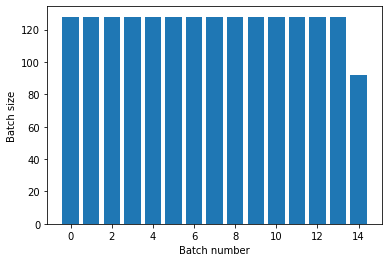

In [135]:
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

<br>

<font size=3 color=maroon>If you need clear epoch separation, put `Dataset.batch` before the repeat:</font>

In [142]:
print(pd.read_csv(titanic_file).shape[0] // 128)
print(pd.read_csv(titanic_file).shape[0] % 128)

4
115


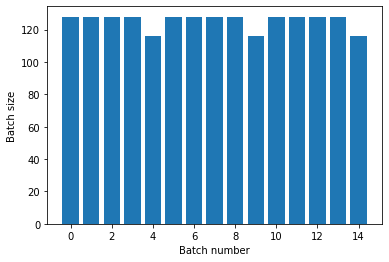

In [143]:
titanic_batches = titanic_lines.batch(128).repeat(3)

plot_batch_sizes(titanic_batches)

<br>

<font size=3 color=maroon>If you would like to perform a custom computation (e.g. to collect statistics) at the end of each epoch then it's simplest to restart the dataset iteration on each epoch:</font>

In [144]:
epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
    for batch in dataset:
        print(batch.shape)
    print("End of epoch: ", epoch)

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  2


<br>

### Randomly shuffling input data

<font size=3 color=maroon>The `Dataset.shuffle()` transformation **maintains a fixed-size buffer** and chooses the next element uniformly **at random** from that buffer.

**Note**: While large buffer_sizes shuffle more thoroughly, they can take a lot of memory, and significant time to fill. Consider using `Dataset.interleave` across files if this becomes a problem.</font>

Add an index to the dataset so you can see the effect:

In [145]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

<br>

In [154]:
# help(dataset.shuffle)

<font size=3 color=maroon>Since the `buffer_size` is 100, and the batch size is 20, the first batch contains no elements with an index over 120.</font>

In [146]:
n, line_batch = next(iter(dataset))
print(n.numpy())

[ 58  28  15  93  38  67  18   1  72  10  34  22  53  79  33  13  51  40
 103  26]


<br>

As with `Dataset.batch` the order relative to `Dataset.repeat` matters.

`Dataset.shuffle` doesn't signal the end of an epoch until the shuffle buffer is empty. So a shuffle placed before a repeat will show every element of one epoch before moving to the next: 

In [147]:
dataset = tf.data.Dataset.zip((counter, lines))   # 由前面知 lines 一共有 628 个元素 (把 csv 的 header 算在内)
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):  # 跳过前面的60个batch，从第61个batch开始来take(5)个batch
    print(n.numpy())
    

# 下面输出的第三np.array只有 8 个元素，因为到它那里已经遍历完一遍数据集了（已经到了 the end of an epoch）

Here are the item ID's near the epoch boundary:

[480 582 548 596 568 619 327 528 552 603]
[610 589 543 602 569 615 490 248 525 581]
[601 482 520 611 495 583 417 571]
[81 43 99  7 53 67  5 10 69  4]
[ 78  52  51  38  16  15  13  61 107  12]


In [149]:
# help(shuffled.skip)

<br>

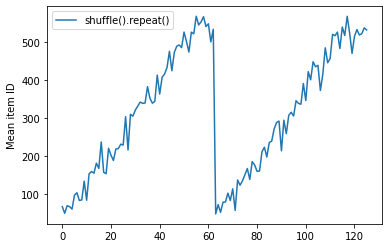

In [150]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()

<br>

<font size=3 color=maroon>But a repeat before a shuffle mixes the epoch boundaries together:</font>

In [151]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(55).take(15):
    print(n.numpy())

Here are the item ID's near the epoch boundary:

[274   3 568 477 606 482 422 497 621 427]
[596 569 592 466 610 531  31 595 594 545]
[599  41 538 472 510 487 535 441  11  19]
[513 608 601 564 583 527 526 313 600 587]
[624  21  20  16 330 547  38  28  47 380]
[622  27 536  30  37  62 352  14 414 591]
[560  34 607  22 578   1  66  85  71  69]
[ 17  57 585  65  90 528  81 626 563  84]
[614  55 562  97  92  72  29  96 559  82]
[489  67  87  83 582  88  54   5 554  33]
[ 10 113  95 124 532  99 106 429  61 521]
[120 571 377 501  49 111 625 442  64  74]
[128 570 577  44 464 618 572  56 148  24]
[145 140  68 573   6  26 589 541  23  77]
[ 58 118  25 155 511 143 126  93  94  40]


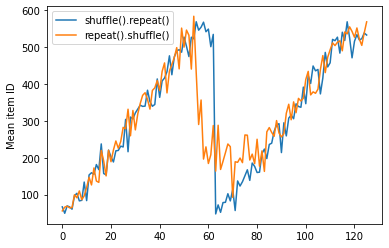

In [152]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()

<br>
<br>
<br>

## Preprocessing data
<br>

The `Dataset.map(f)` transformation produces a new dataset by applying a given function `f` to each element of the input dataset. It is based on the [map()](https://en.wikipedia.org/wiki/Map_\(higher-order_function\)) function that is commonly applied to lists (and other structures) in functional programming languages. 

The function `f` takes the `tf.Tensor` objects that represent a single element in the input, and returns the `tf.Tensor` objects that will represent a single element in the new dataset. Its implementation uses standard TensorFlow operations to transform one element into another.

This section covers common examples of how to use `Dataset.map()`.

<br>

### Decoding image data and resizing it

<!-- TODO(markdaoust): link to image augmentation when it exists -->
When training a neural network on real-world image data, it is often necessary to convert images of different sizes to a common size, so that they may be batched into a fixed size.

Rebuild the flower filenames dataset:

In [155]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

Write a function that manipulates the dataset elements.

In [156]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
    parts = tf.strings.split(filename, os.sep)
    label = parts[-2]

    image = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    
    return image, label

Test that it works.

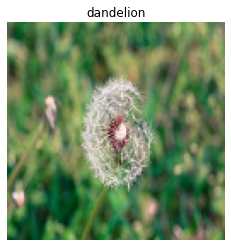

In [157]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(label.numpy().decode('utf-8'))
    plt.axis('off')

show(image, label)

<br>

Map it over the dataset.

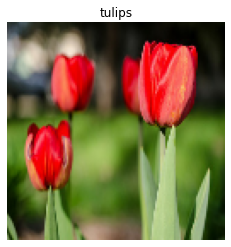

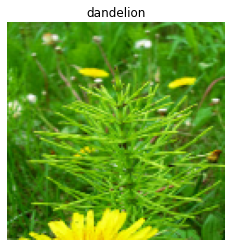

In [158]:
images_ds = list_ds.map(parse_image)

for image, label in images_ds.take(2):
    show(image, label)

<br>
<br>

### Applying arbitrary Python logic

<font size=3 color=maroon>For performance reasons, use TensorFlow operations for preprocessing your data whenever possible. However, it is sometimes useful to call external Python libraries when parsing your input data. You can use the `tf.py_function()` operation in a `Dataset.map()` transformation.</font>

For example, if you want to apply a random rotation, the `tf.image` module only has `tf.image.rot90`, which is not very useful for image augmentation. 

Note: `tensorflow_addons` has a TensorFlow compatible `rotate` in `tensorflow_addons.image.rotate`.

To demonstrate `tf.py_function`, try using the `scipy.ndimage.rotate` function instead:

In [159]:
import scipy.ndimage as ndimage

def random_rotate_image(image):
    image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


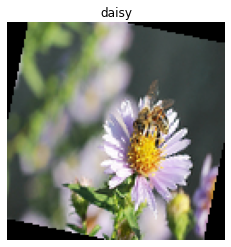

In [161]:
image, label = next(iter(images_ds))
image = random_rotate_image(image)
show(image, label)

<br>

<font size=3 color=maroon>To use this function with `Dataset.map` **the same caveats apply** as with `Dataset.from_generator`, you need to describe the return shapes and types when you apply the function:</font>

In [162]:
def tf_random_rotate_image(image, label):
    im_shape = image.shape
    [image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


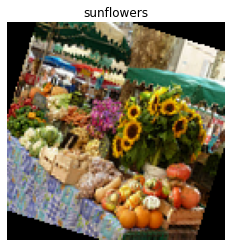

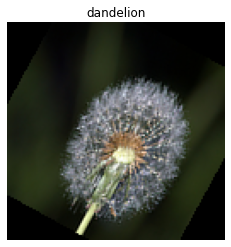

In [164]:
rot_ds = images_ds.map(tf_random_rotate_image)

for image, label in rot_ds.take(2):
    show(image, label)

<br>
<br>

### Parsing `tf.Example` protocol buffer messages

<font size=3 color=maroon>Many input pipelines extract `tf.train.Example` protocol buffer messages from a TFRecord format. Each `tf.train.Example` record contains one or more "features", and the input pipeline typically converts these features into tensors.</font>

In [165]:
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", 
                                         "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001",
                                         cache_dir="D:/KeepStudy/0_Coding",
                                         cache_subdir="0_dataset")

dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

<font size=3 color=maroon>You can work with `tf.train.Example` protos outside of a `tf.data.Dataset` to understand the data:</font>

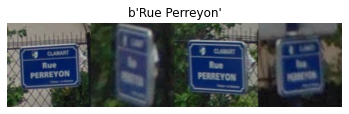

In [166]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

feature = parsed.features.feature
raw_img = feature['image/encoded'].bytes_list.value[0]
img = tf.image.decode_png(raw_img)
plt.imshow(img)
plt.axis('off')
_ = plt.title(feature["image/text"].bytes_list.value[0])

In [167]:
raw_example = next(iter(dataset))

In [168]:
def tf_parse(eg):
    example = tf.io.parse_example(eg[tf.newaxis], 
                                  {'image/encoded': tf.io.FixedLenFeature(shape=(), 
                                                                          dtype=tf.string),
                                   'image/text': tf.io.FixedLenFeature(shape=(), dtype=tf.string)
                                  })
    
    return example['image/encoded'][0], example['image/text'][0]

In [169]:
img, txt = tf_parse(raw_example)
print(txt.numpy())
print(repr(img.numpy()[:20]), "...")

b'Rue Perreyon'
b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X' ...


In [170]:
decoded = dataset.map(tf_parse)
decoded

<MapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [171]:
image_batch, text_batch = next(iter(decoded.batch(10)))
image_batch.shape

TensorShape([10])

<br>
<br>

<a id="time_series_windowing"></a>

### Time series windowing

For an end to end time series example see: [Time series forecasting](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/tutorials/structured_data/time_series.ipynb).

Time series data is often organized with the time axis intact.

Use a simple `Dataset.range` to demonstrate:

In [172]:
range_ds = tf.data.Dataset.range(100000)

<br>

Typically, models based on this sort of data will want a contiguous time slice. 

The simplest approach would be to batch the data:

#### Using `batch`

In [175]:
# help(range_ds.batch)

In [173]:
batches = range_ds.batch(10, drop_remainder=True)

for batch in batches.take(5):
    print(batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]


<br>

Or to make dense predictions one step into the future, you might shift the features and labels by one step relative to each other:

In [176]:
def dense_1_step(batch):
  # Shift features and labels one step relative to each other.
  return batch[:-1], batch[1:]

predict_dense_1_step = batches.map(dense_1_step)

for features, label in predict_dense_1_step.take(3):
    print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8]  =>  [1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18]  =>  [11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28]  =>  [21 22 23 24 25 26 27 28 29]


<br>

To predict a whole window instead of a fixed offset you can split the batches into two parts:

In [177]:
batches = range_ds.batch(15, drop_remainder=True)

def label_next_5_steps(batch):
    return (batch[:-5],   # Inputs: All except the last 5 steps
            batch[-5:])   # Labels: The last 5 steps

predict_5_steps = batches.map(label_next_5_steps)

for features, label in predict_5_steps.take(3):
    print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]  =>  [25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]  =>  [40 41 42 43 44]


<br>

To allow some overlap between the features of one batch and the labels of another, use `Dataset.zip`:

In [178]:
feature_length = 10
label_length = 3

features = range_ds.batch(feature_length, drop_remainder=True)
labels = range_ds.batch(feature_length).skip(1).map(lambda labels: labels[:label_length])

predicted_steps = tf.data.Dataset.zip((features, labels))

for features, label in predicted_steps.take(5):
    print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12]
[10 11 12 13 14 15 16 17 18 19]  =>  [20 21 22]
[20 21 22 23 24 25 26 27 28 29]  =>  [30 31 32]
[30 31 32 33 34 35 36 37 38 39]  =>  [40 41 42]
[40 41 42 43 44 45 46 47 48 49]  =>  [50 51 52]


<br>

#### Using `window`

<font size=3 color=maroon>While using `Dataset.batch` works, there are situations where you may need finer control. The `Dataset.window` method gives you complete control, but requires some care: it returns a `Dataset` of `Datasets`.</font><br>
See [Dataset structure](#dataset_structure) for details.

In [179]:
window_size = 5

windows = range_ds.window(window_size, shift=1)
for sub_ds in windows.take(5):
    print(sub_ds)

<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


<br>

<font size=3 color=maroon>The `Dataset.flat_map` method can take a dataset of datasets and flatten it into a single dataset:</font>

In [180]:
 for x in windows.flat_map(lambda x: x).take(30):
     print(x.numpy(), end=' ')

0 1 2 3 4 1 2 3 4 5 2 3 4 5 6 3 4 5 6 7 4 5 6 7 8 5 6 7 8 9 

<br>

<font size=3 color=maroon>In nearly all cases, you will want to `.batch` the dataset first:</font>

In [181]:
def sub_to_batch(sub):
    return sub.batch(window_size, drop_remainder=True)

for example in windows.flat_map(sub_to_batch).take(5):
    print(example.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]


Now, you can see that the `shift` argument controls how much each window moves over.

Putting this together you might write this function:

In [182]:
def make_window_dataset(ds, window_size=5, shift=1, stride=1):
    windows = ds.window(window_size, shift=shift, stride=stride)

    def sub_to_batch(sub):
        return sub.batch(window_size, drop_remainder=True)

    windows = windows.flat_map(sub_to_batch)
    
    return windows


In [183]:
ds = make_window_dataset(range_ds, window_size=10, shift = 5, stride=3)

for example in ds.take(10):
    print(example.numpy())

[ 0  3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34 37]
[15 18 21 24 27 30 33 36 39 42]
[20 23 26 29 32 35 38 41 44 47]
[25 28 31 34 37 40 43 46 49 52]
[30 33 36 39 42 45 48 51 54 57]
[35 38 41 44 47 50 53 56 59 62]
[40 43 46 49 52 55 58 61 64 67]
[45 48 51 54 57 60 63 66 69 72]


Then it's easy to extract labels, as before:

In [184]:
dense_labels_ds = ds.map(dense_1_step)

for inputs,labels in dense_labels_ds.take(3):
    print(inputs.numpy(), "=>", labels.numpy())

[ 0  3  6  9 12 15 18 21 24] => [ 3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29] => [ 8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34] => [13 16 19 22 25 28 31 34 37]


<br>
<br>

### Resampling

<font size=3 color=maroon>When working with a dataset that is very class-imbalanced, you may want to resample the dataset. `tf.data` provides two methods to do this. The credit card fraud dataset is a good example of this sort of problem.

Note: See [Imbalanced Data](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/imbalanced_data.ipynb) for a full tutorial.</font>


In [185]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/download.tensorflow.org/data/creditcard.zip',
    fname='creditcard.zip',
    extract=True,
    cache_dir="D:/KeepStudy/0_Coding/",
    cache_subdir="0_dataset")

csv_path = zip_path.replace('.zip', '.csv')

69165056/69155632 [==============================] - 29s 0us/step


In [189]:
csv_path

'D:/KeepStudy/0_Coding/0_dataset\\creditcard.csv'

In [186]:
creditcard_ds = tf.data.experimental.make_csv_dataset(csv_path, 
                                                      batch_size=1024, 
                                                      label_name="Class",
                                                      # Set the column types: 30 floats and an int.
                                                      column_defaults=[float()]*30+[int()])

Now, check the distribution of classes, it is highly skewed:

In [187]:
def count(counts, batch):
    features, labels = batch
    class_1 = labels == 1
    class_1 = tf.cast(class_1, tf.int32)

    class_0 = labels == 0
    class_0 = tf.cast(class_0, tf.int32)

    counts['class_0'] += tf.reduce_sum(class_0)
    counts['class_1'] += tf.reduce_sum(class_1)

    return counts

In [188]:
counts = creditcard_ds.take(10).reduce(initial_state={'class_0': 0, 'class_1': 0},
                                       reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

fractions = counts/counts.sum()
print(fractions)

[0.9955 0.0045]


<br>

<font size=3 color=maroon>A common approach to training with an imbalanced dataset is to balance it. `tf.data` includes a few methods which enable this workflow:</font>

#### Datasets sampling

One approach to resampling a dataset is to use `sample_from_datasets`. This is more applicable when you have a separate `data.Dataset` for each class.

Here, just use filter to generate them from the credit card fraud data:

In [192]:
# 陈锐平添加，先简单看一下数据
pd.read_csv(csv_path).head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [193]:
negative_ds = (creditcard_ds.unbatch()
                            .filter(lambda features, label: label==0)
                            .repeat())

positive_ds = (creditcard_ds.unbatch()
                            .filter(lambda features, label: label==1)
                            .repeat())

In [194]:
for features, label in positive_ds.batch(10).take(1):
    print(label.numpy())

[1 1 1 1 1 1 1 1 1 1]


<br>

<font size=3 color=maroon>To use `tf.data.Dataset.sample_from_datasets` pass the datasets, and the weight for each:</font>

In [198]:
balanced_ds = tf.data.Dataset \
                     .sample_from_datasets([negative_ds, positive_ds], [0.5, 0.5]).batch(10)

Now the dataset produces examples of each class with 50/50 probability:

In [199]:
for features, labels in balanced_ds.take(10):
    print(labels.numpy())

[1 1 0 1 0 0 0 0 1 0]
[1 1 1 1 1 0 1 0 1 1]
[0 1 0 0 1 1 1 0 1 1]
[1 0 0 0 0 1 1 0 1 0]
[1 0 0 0 0 1 1 1 0 1]
[0 1 1 1 0 1 0 1 1 1]
[0 0 0 1 1 0 0 0 0 1]
[1 0 0 0 1 0 1 1 1 1]
[0 1 0 1 0 1 0 0 1 0]
[0 0 1 0 0 0 1 1 1 1]


<br>

#### Rejection resampling

<font size=3 color=maroon>One problem with the above `Dataset.sample_from_datasets` approach is that it needs a separate `tf.data.Dataset` per class. You could use `Dataset.filter` to create those two datasets, but that results in all the data being loaded twice.

The `data.Dataset.rejection_resample` method can be applied to a dataset to rebalance it, while only loading it once. Elements will be dropped from the dataset to achieve balance.</font>

`data.Dataset.rejection_resample` takes a `class_func` argument. This `class_func` is applied to each dataset element, and is used to determine which class an example belongs to for the purposes of balancing.

The goal here is to balance the lable distribution, and the elements of `creditcard_ds` are already `(features, label)` pairs. So the `class_func` just needs to return those labels:

In [200]:
def class_func(features, label):
    return label

<br>

<font size=3 color=maroon>The resampling method deals with individual examples, so in this case you must `unbatch` the dataset before applying that method.

The method needs a target distribution, and optionally an initial distribution estimate as inputs.</font>

In [201]:
resample_ds = (creditcard_ds.unbatch()
                            .rejection_resample(class_func, 
                                                target_dist=[0.5,0.5],
                                                initial_dist=fractions)
                            .batch(10))

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



<br>

<font size=3 color=maroon>The `rejection_resample` method returns `(class, example)` pairs where the `class` is the output of the `class_func`. In this case, the `example` was already a `(feature, label)` pair, so use `map` to drop the extra copy of the labels:</font>

In [202]:
balanced_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

<br>

Now the dataset produces examples of each class with 50/50 probability:

In [203]:
for features, labels in balanced_ds.take(10):
    print(labels.numpy())

[1 0 0 1 0 0 1 1 0 0]
[1 0 0 1 1 0 1 1 0 0]
[1 1 1 0 1 0 0 0 0 1]
[1 0 1 0 0 1 1 0 0 1]
[1 0 1 1 0 0 1 0 1 1]
[1 1 0 1 1 0 0 1 0 1]
[1 0 1 1 0 1 1 1 0 0]
[0 0 1 0 1 1 1 1 1 1]
[1 1 0 0 0 0 0 0 1 1]
[1 0 1 1 1 1 1 1 0 1]


<br>
<br>
<br>

## Iterator Checkpointing

Tensorflow supports [taking checkpoints](https://www.tensorflow.org/guide/checkpoint) so that when your training process restarts it can restore the latest checkpoint to recover most of its progress. <font size=3 color=maroon>In addition to checkpointing the model variables, you can also checkpoint the progress of the dataset iterator. This could be useful if you have a large dataset and don't want to start the dataset from the beginning on each restart. **Note** however that iterator checkpoints may be large, since transformations such as `shuffle` and `prefetch` require buffering elements within the iterator. </font>

To include your iterator in a checkpoint, pass the iterator to the `tf.train.Checkpoint` constructor.

In [204]:
range_ds = tf.data.Dataset.range(20)

iterator = iter(range_ds)
ckpt = tf.train.Checkpoint(step=tf.Variable(0), iterator=iterator)
manager = tf.train.CheckpointManager(ckpt, '/tmp/my_ckpt', max_to_keep=3)

print([next(iterator).numpy() for _ in range(5)])    # [0, 1, 2, 3, 4]

save_path = manager.save()

print([next(iterator).numpy() for _ in range(5)])    # [5, 6, 7, 8, 9]

ckpt.restore(manager.latest_checkpoint)

print([next(iterator).numpy() for _ in range(5)])    # [5, 6, 7, 8, 9]

[0, 1, 2, 3, 4]
[5, 6, 7, 8, 9]
[5, 6, 7, 8, 9]


<br>

<font size=3 color=maroon>**Note**: It is not possible to checkpoint an iterator which relies on external state such as a `tf.py_function`. Attempting to do so will raise an exception complaining about the external state.</font>

<br>
<br>
<br>

## Using tf.data with tf.keras

The `tf.keras` API simplifies many aspects of creating and executing machine learning models. Its `.fit()` and `.evaluate()` and `.predict()` APIs support datasets as inputs. Here is a quick dataset and model setup:

In [205]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0
labels = labels.astype(np.int32)

In [206]:
fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
fmnist_train_ds = fmnist_train_ds.shuffle(5000).batch(32)

model = tf.keras.Sequential([tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(10)])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

<br>

 Passing a dataset of `(feature, label)` pairs is all that's needed for `Model.fit` and `Model.evaluate`:

In [207]:
model.fit(fmnist_train_ds, epochs=2)

Epoch 1/2
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5985 - accuracy: 0.7984
Epoch 2/2
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4609 - accuracy: 0.8432


<br>

<font size=3 color=maroon>If you pass an infinite dataset, for example by calling `Dataset.repeat()`, you just need to also pass the `steps_per_epoch` argument:</font>

In [208]:
model.fit(fmnist_train_ds.repeat(), epochs=2, steps_per_epoch=20)

Epoch 1/2
20/20 [==============================] - 0s 2ms/step - loss: 0.4650 - accuracy: 0.8391
Epoch 2/2
20/20 [==============================] - 0s 2ms/step - loss: 0.4436 - accuracy: 0.8547


<br>

<font size=3 color=maroon>For evaluation you can pass the number of evaluation steps:</font>

In [209]:
loss, accuracy = model.evaluate(fmnist_train_ds)
print("Loss :", loss)
print("Accuracy :", accuracy)

1875/1875 [==============================] - 3s 2ms/step - loss: 0.4353 - accuracy: 0.8506
Loss : 0.43529897928237915
Accuracy : 0.8505666851997375


<br>

<font size=3 color=maroon>For long datasets, set the number of steps to evaluate:</font>

In [210]:
loss, accuracy = model.evaluate(fmnist_train_ds.repeat(), steps=10)
print("Loss :", loss)
print("Accuracy :", accuracy)

10/10 [==============================] - 0s 2ms/step - loss: 0.3333 - accuracy: 0.8906
Loss : 0.33328455686569214
Accuracy : 0.890625


<br>

<font size=3 color=maroon>The labels are not required in when calling `Model.predict`. </font>

In [211]:
predict_ds = tf.data.Dataset.from_tensor_slices(images).batch(32)
result = model.predict(predict_ds, steps = 10)
print(result.shape)

(320, 10)


<br>

<font size=3 color=maroon>But the labels are ignored if you do pass a dataset containing them:</font>

In [212]:
result = model.predict(fmnist_train_ds, steps = 10)
print(result.shape)

(320, 10)


<br>

```python
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.
```

<br>
<br>
<br>